***
<font color='#72A8DA' size="24">Artificial Intelligence </font>  
<font>Machine Learning Project 2022-2023</font> 
***
<br><br>

|   | Team  Members             |         |
|---|---------------------------|---------|
| 1 |   Christos Patrinopoulos  | 3200150 |
| 2 |   Alviona Mancho          | 3200098 |

![AI image](https://www.ionos.com/digitalguide/fileadmin/_processed_/c/0/csm_deep-learning-vs-machine-learning-t_8d403d65ff.jpg)

### Imports

In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import pandas as pd
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from tensorflow.keras.utils import plot_model
from IPython.display import Image 

### Fetch Data

In [2]:
def data_fetch():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

    word_index = tf.keras.datasets.imdb.get_word_index()
    index2word = dict((i + 3, word) for (word, i) in word_index.items())
    index2word[0] = '[pad]'
    index2word[1] = '[bos]'
    index2word[2] = '[oov]'
    x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
    x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])
    return x_train, y_train, x_test, y_test

### Vectorize Examples

In [3]:
def vectorize_examples(vocabulary, x_train, x_test=None):
    binary_vectorizer = CountVectorizer(binary=True, vocabulary=vocabulary.keys())

    x_train_binary = binary_vectorizer.fit_transform(x_train)
    x_train_binary = x_train_binary.toarray()

    if(x_test is not None):
        x_test_binary = binary_vectorizer.transform(x_test)
        x_test_binary = x_test_binary.toarray()
    else:
        x_test_binary = None

    return x_train_binary, x_test_binary

### Create Vocabulary

In [4]:
def IG(class_, feature):
  classes = set(class_)

  Hc = 0
  for c in classes:
    pc = list(class_).count(c)/len(class_)
    Hc += - pc * math.log(pc, 2)
  feature_values = set(feature)

  Hc_feature = 0
  for feat in feature_values:
    
    #pf --> P(X=x)
    pf = list(feature).count(feat)/len(feature)
    indices = [i for i in range(len(feature)) if feature[i] == feat]
    classes_of_feat = [class_[i] for i in indices]
    for c in classes:
        #pcf --> P(C=c|X=x)
        pcf = classes_of_feat.count(c)/len(classes_of_feat)
        if pcf != 0: 
            # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
            temp_H = - pf * pcf * math.log(pcf, 2)
            #sum for all values of C (class) and X (values of specific feature)
            Hc_feature += temp_H
  ig = Hc - Hc_feature
  return ig 



def create_vocabulary(x_train, y_train, n, k, m, l):
    """  
        n : skip n most frequent words
        k : skip k least frequent words
        m : keep m most frequent remaining words
        l : keep l most useful words (metric: Information Gain)
    """
    frequency_dict  = dict()

    for text in x_train:
        tokens = set(text.split())
        for token in tokens:
            if token in frequency_dict.keys():
                frequency_dict[token] += 1
            else:
                frequency_dict[token] = 1

    # Skip n most frequent and k least frequent, keep m most frequent remaining words
    frequency_dict.pop('[pad]', ' ')
    frequency_dict.pop('[bos]', ' ')
    frequency_dict.pop('[oov]', ' ')
    vocabulary = sorted(frequency_dict.items(), key = lambda x:x[1]) 
    vocabulary = vocabulary[k:len(vocabulary) - n]
    vocabulary = dict(vocabulary[len(vocabulary) - m:])

    # Then calculate IG of remaining words and keep l most valuable
    x_train_binary, x_test_binary = vectorize_examples(vocabulary, x_train)

    infogain_dict = dict()

    for i in tqdm(range(len(vocabulary))):
        feature_i = [example[i] for example in x_train_binary]
        infogain_dict[list(vocabulary.keys())[i]] = IG(y_train, feature_i)

    vocabulary = sorted(infogain_dict.items(), key = lambda x:x[1], reverse=True) 
    vocabulary = vocabulary[:l]
    vocabulary = dict(vocabulary)
    

    return vocabulary   

## Naive Bayes

In [5]:
class NaiveBayesClassifier():
    def __init__(self):
        self.prob_y_1 = None
        self.prob_y_0 = None
        self.bound_prob = None

    
    def fit(self, x_train_binary, y_train):
        X = x_train_binary
        y = y_train

        num_examples = X.shape[0]
        num_features = X.shape[1]

        #P(C=1)
        self.prob_y_1 = sum(y) / len(y)
        #P(C=0)
        self.prob_y_0 = 1 - self.prob_y_1

        #P(Xi = 1 | C=0) ->row0
        #P(Xi = 1 | C=1) ->row1
        self.bound_prob = np.zeros((2, num_features)) 


        #find Xs that belong to Category y=0
        X_filtered_y_0 = [ X[i] for i in range(num_examples) if y[i] == 0]                  #P(Xi = 1 | C=0)
        X_filtered_y_0 = np.array(X_filtered_y_0)
        self.bound_prob[0] = (X_filtered_y_0.sum(axis=0) + 1) / (len(X_filtered_y_0) + 2)   #Laplace


        #find Xs that belong to Category y=1
        X_filtered_y_1 = [ X[i] for i in range(num_examples) if y[i] == 1]                  #P(Xi = 1 | C=1)
        X_filtered_y_1 = np.array(X_filtered_y_1)
        self.bound_prob[1] = (X_filtered_y_1.sum(axis=0) + 1) / (len(X_filtered_y_1) + 2)   #Laplace
    


    def predict(self, x_test_binary):
        X = x_test_binary

        num_examples = X.shape[0]
        num_features = X.shape[1]

        y_pred = list()
        for example in X:
            
            """
            Attempt 1 using log
            fitted_bound_prob_0 = sum( math.log(self.bound_prob[0][i]) if example[i] == 1 else  math.log(1-self.bound_prob[0][i]) for i in range(num_features) )
            fitted_bound_prob_1 = sum( math.log(self.bound_prob[1][i]) if example[i] == 1 else  math.log(1-self.bound_prob[1][i]) for i in range(num_features) )

            prob_class_0 = math.log(self.prob_y_0) + fitted_bound_prob_0          #P(C=0 | X) = P(X| C=0)*P(C=0)
            prob_class_1 = math.log(self.prob_y_1) + fitted_bound_prob_1          #P(C=1 | X)
            """

            """
            Attempt 2 using prod (faster but loses accuracy)
            fitted_bound_prob_0 = np.prod(np.array([self.bound_prob[0][i] if example[i] == 1 else  1-self.bound_prob[0][i] for i in range(num_features) ]))
            fitted_bound_prob_1 = np.prod(np.array([self.bound_prob[1][i] if example[i] == 1 else  1-self.bound_prob[1][i] for i in range(num_features) ]))

            prob_class_0 = self.prob_y_0 * fitted_bound_prob_0          #P(C=0 | X) = P(X| C=0)*P(C=0)
            prob_class_1 = self.prob_y_1 * fitted_bound_prob_1          #P(C=1 | X)
            """

            filter1 = np.array([0 if example[i]==1 else 1 for i in range(num_features)])
            filter2 = np.array([1 if example[i]==1 else -1 for i in range(num_features)])

            fitted_bound_prob_0 = np.prod(np.add(filter1, (self.bound_prob[0] * filter2)))
            fitted_bound_prob_1 = np.prod(np.add(filter1, (self.bound_prob[1] * filter2)))

            prob_class_0 = (self.prob_y_0) * fitted_bound_prob_0          #P(C=0 | X) = P(X| C=0)*P(C=0)
            prob_class_1 = (self.prob_y_1) * fitted_bound_prob_1          #P(C=1 | X)

            if prob_class_0 > prob_class_1:
                y_pred.append(0)
            else:
                y_pred.append(1)

        return y_pred


    def __str__(self):
        return "Custom Naive Bayes()"

## Logistic Regression

In [6]:
class CustomLogisticRegression():
    def __init__(self, n_iters, learning_rate, regularizator):
        self.n_iters = n_iters
        self.learing_rate = learning_rate
        self.regularizator = regularizator
        self.weights = None
    
    @staticmethod
    def pos_category_sigmoid(t):
        return 1 / (1 + math.exp(-t))


    def fit(self, x_train_binary, y_train):
        X, X_val, y, y_val = train_test_split(x_train_binary, y_train, test_size=0.2)

        #X = x_train_binary
        #y = y_train

        num_examples = X.shape[0]
        num_features = X.shape[1]

        col = np.ones(num_examples)
        X = np.insert(X, 0, col, axis=1)            #insert 1 in every x_vector for w0

        F = np.insert(X, 0, y, axis=1)              #insert y_train array to shuffle examples in for loop

        self.weights = np.zeros(num_features+1)

        best_accuracy = 0
        best_epoch = 0
        n_epochs_unchanged = 0

        for epoch in range(1, self.n_iters+1):
            np.random.shuffle(F)                    #random permutation of examples
            X = F[:,1:]
            y = F[:,0]
            for i in range(num_examples):
                example = X[i]
                prob_positive = self.pos_category_sigmoid(self.weights.dot(example))              # P(c+ | xi)
                weight_modification = self.learing_rate * (y[i] - prob_positive) * example        # [yi - P(c+ | xi)] * xi
                self.weights = (1 - 2*self.regularizator*self.learing_rate) * self.weights + weight_modification

            # Early Stopping
            accuracy = accuracy_score(y_val, self.predict(X_val))
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_epoch = epoch
                best_weights = self.weights
                n_epochs_unchanged = 0
            else:
                n_epochs_unchanged += 1

            if n_epochs_unchanged == 20:
                self.weights = best_weights
                break       
        print("Best epoch: "+str(best_epoch))
       
        X = np.delete(X, 0, axis=1)                 #remove 1s column again (needed previously for w0)
        return X,y


    def predict(self, x_test_binary):

        X = x_test_binary

        num_examples = X.shape[0]
        num_features = X.shape[1]

        col = np.ones(num_examples)
        X = np.insert(X, 0, col, axis=1)            #insert 1 in x_vector for w0

        y_pred = list()
        for example in X:
            if np.sign(self.weights.dot(example)) == 1:
                y_pred.append(1)
            else:
                y_pred.append(0)

        return np.array(y_pred)

    
    def __str__(self):
        return "Custom Logistic Regression()"


In [7]:
def find_best_regularizator(x_train_part, x_val_part, y_train_part, y_val_part):
    best_acc = 0
    best_regularizator = 0
    best_classifier = None

    n_iters_unchanged = 1
    
    for regularizator in range(0, 100, 1):
        regularizator = regularizator / 100 + 1e-15
        lr = CustomLogisticRegression(n_iters=100, learning_rate=0.001, regularizator=regularizator)
        lr.fit(x_train_binary=x_train_part, y_train=y_train_part)
        y_pred_val = lr.predict(x_val_part)                 

        acc = accuracy_score(y_val_part, y_pred_val)
        print("\tRegularizator: ", regularizator, "Accuracy on dev: ", acc)
        if acc > best_acc:
            best_acc = acc
            best_regularizator = regularizator
            best_classifier = lr
            n_iters_unchanged = 0
        else:
            n_iters_unchanged += 1

        if n_iters_unchanged == 5:
            break 
        
    return best_classifier, best_regularizator, best_acc

## Bidirectional GRU RNN

In [8]:
class BiGRU_RNN():
    def __init__(self, vectorizer, num_layers, emb_size, h_size, embedding_matrix=None):
        self.vectorizer = vectorizer
        self.embedding_matrix = embedding_matrix
        self.num_layers = num_layers
        self.emb_size = emb_size
        self.h_size = h_size
        #self.model = self.create_bi_GRU_RNN()

    def create_bi_GRU_RNN(self):
        inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='txt_input')
        x = self.vectorizer(inputs)
        x = tf.keras.layers.Embedding(input_dim=len(self.vectorizer.get_vocabulary()),
                                        output_dim=self.emb_size, name='word_embeddings',
                                        mask_zero=True)(x)

        x = tf.keras.layers.Dropout(rate=0.25)(x)

        for n in range(self.num_layers):
            if n != self.num_layers - 1:
                x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=self.h_size, 
                                    name=f'bi-GRU_cell_{n}', 
                                    return_sequences=True,
                                    dropout=0.2))(x)
            else:
                x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=self.h_size, 
                                                name=f'bi-GRU_cell_{n}',
                                                dropout=0.2))(x)

        x = tf.keras.layers.Dropout(rate=0.5)(x)
        o = tf.keras.layers.Dense(units=1, activation='sigmoid', name='lr')(x)
        return tf.keras.models.Model(inputs=inputs, outputs=o, name='RNN')


    def fit(self, x_train, y_train, epochs=1, verbose=1, batch_size=32, validation_split=0):
        self.model = self.create_bi_GRU_RNN()
        self.model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=[tf.keras.metrics.BinaryAccuracy(),
                                    tf.keras.metrics.Precision(),
                                    tf.keras.metrics.Recall()])
                                    
        return self.model.fit(x=x_train, y=y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_split=validation_split)


    def predict(self, x_test):
        y_pred = self.model.predict(x_test)
        y_pred_binary = [1 if example[0] >= 0.5 else 0 for example in y_pred]
        
        return y_pred_binary

    def __str__(self):
        return "BiGRU RNN()"

## Curves

In [9]:
def learning_curve(predictor, x_train, y_train, x_test, y_test, n_splits):
  

  def append(scores): 
    y_pred_train = pred.predict(curr_x_train_part)        # validation data is excluded, only training data considered
    y_pred_test = pred.predict(x_test)

    for f in scores:
      f[1].append(f[0](curr_y_train_part, y_pred_train))  # validation data is excluded, only training data considered
      f[2].append(f[0](y_test, y_pred_test))

    splits.append(len(curr_x_train_part))
    

  def plotter(scores):
    fig, axs = plt.subplots(4, 2, figsize=(10, 17))      

    i = pred.__str__().find("(")
    suptitle = pred.__str__()[:i]
    fig.suptitle(suptitle, size="25")

    subplots = [ax for ax in axs.flat]
    for i in range(0, len(subplots), 2):
        f = scores[i//2]

        subplot = subplots[i]       # 1st subplot of metric f, zoomed in
        l1 = subplot.plot(splits, f[1], 'o-', color="royalblue", label="Training")
        l2 = subplot.plot(splits, f[2], '-', color="crimson", label="Testing")
        subplot.grid()
        subplot.set_xticks(splits, splits)
        subplot.set_title(f[0].__name__.replace("_", " ").capitalize(), loc='left', style='italic', bbox = dict(facecolor = 'white', boxstyle="round"))

        subplot = subplots[i+1]     # 2nd subplot of metric f, zoomed out  (specified range of y axis)
        l1 = subplot.plot(splits, f[1], 'o-', color="royalblue", label="Training")
        l2 = subplot.plot(splits, f[2], '-', color="crimson", label="Testing")
        subplot.grid()
        subplot.set_xticks(splits, splits)
        subplot.set_ylim(0, 1)
  
    fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")
    fig.supxlabel("Training Set Size")
    fig.supylabel("Metrics score")
    plt.subplots_adjust(right=0.9)
    plt.show()



  pred = predictor

  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)

  splits = list()
  train_accuracy, test_accuracy = list(), list()
  train_precision, test_presicion = list(), list()
  train_recall, test_recall = list(), list()
  train_f1, test_f1 = list(), list()

  scores = [(accuracy_score,train_accuracy, test_accuracy), 
      (precision_score, train_precision, test_presicion),
      (recall_score, train_recall, test_recall),
      (f1_score, train_f1, test_f1)
    ]

  curr_x = x_splits[0]
  curr_y = y_splits[0]

  if type(predictor) is CustomLogisticRegression:             # the only classifier to be using validation data is our CustomLogisticRegression (early stopping), 
    curr_x_train_part, curr_y_train_part = pred.fit(curr_x, curr_y) # so in this case only the part of data actually used as training data should be considered as "training data"
  else:
    pred.fit(curr_x, curr_y)
    curr_x_train_part = curr_x
    curr_y_train_part = curr_y

  append(scores)  #predict then append

  for i in tqdm(range(1, len(x_splits))):

    pred = predictor

    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)

    if type(predictor) is CustomLogisticRegression:             # the only classifier to be using validation data is our CustomLogisticRegression (early stopping), 
      curr_x_train_part, curr_y_train_part = pred.fit(curr_x, curr_y) # so in this case only the part of data actually used as training data should be considered as "training data"
    else:
      curr_x_train_part = curr_x
      curr_y_train_part = curr_y
      pred.fit(curr_x, curr_y)
      

    append(scores) #predict then append
  
  # Show reporting table
  report_table = pd.DataFrame([x/len(x_train)*100 for x in splits], columns= ["Train Size (%)"]).set_index("Train Size (%)")
  report_table['Accuracy Train'] = train_accuracy
  report_table['Accuracy Test'] = test_accuracy
  report_table['Precision Train'] = train_precision
  report_table['Precision Test'] = test_presicion
  report_table['Recall Train'] = train_recall
  report_table['Recall Test'] = test_recall
  report_table['F1 Train'] = train_f1
  report_table['F1 Test'] = test_f1
  display(report_table)

  # Show reporting plots
  plotter(scores)
  return report_table

In [10]:
def loss_plot(history):
    kind = "loss"

    train = history.history[kind]
    val = history.history['val_' + kind]
    
    epochs = range(1, len(train)+1)
    plt.figure(figsize=(12,9))
    plt.plot(epochs, train, 'royalblue', label='Training ' + kind)
    plt.plot(epochs, val, 'orange', label='Validation ' + kind)
    plt.title('Training and validation ' + kind) 
    plt.xlabel('Epochs')
    plt.ylabel(kind)
    plt.legend()
    plt.show()

In [11]:
def make_comparisons(df_predictor1, df_predictor2):
    df_diffs = df_predictor1 - df_predictor2.values
    df_diffs = df_diffs.T
    sns.heatmap(df_diffs, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), vmin=0, vmax=0.1, fmt=".3f")

## Training & Testing

### Preparing data

In [12]:
# Fetching data
x_train_imdb, y_train_imdb, x_test_imdb, y_test_imdb = data_fetch()

# Creating vocabulary
vocabulary = create_vocabulary(x_train=x_train_imdb, y_train=y_train_imdb, n=50, k = 85000, m=2500, l=1000)

# Vectorizing examples
x_train_imdb_binary, x_test_imdb_binary = vectorize_examples(vocabulary=vocabulary, x_train=x_train_imdb, x_test=x_test_imdb)

100%|██████████| 2500/2500 [00:52<00:00, 47.55it/s]


### Training, Using and Curves of Naive Bayes Classifier

#### Custom Naive Bayes

In [13]:
# Training Naive Bayes Classifier
nb = NaiveBayesClassifier()
nb.fit(x_train_binary=x_train_imdb_binary, y_train=y_train_imdb)

# Using Naive Bayes Classifier
y = nb.predict(x_test_binary=x_test_imdb_binary)
print(classification_report(y_test_imdb, y))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.85      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



100%|██████████| 4/4 [01:56<00:00, 29.20s/it]


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.865,0.853,0.862,0.851,0.875,0.856,0.869,0.854
40.0,0.864,0.851,0.854,0.845,0.880,0.861,0.867,0.853
60.0,0.861,0.853,0.851,0.847,0.875,0.861,0.863,0.854
80.0,0.861,0.853,0.852,0.849,0.874,0.860,0.863,0.854
100.0,0.859,0.853,0.847,0.847,0.876,0.863,0.861,0.855


C:\Users\chris\AppData\Local\Temp/ipykernel_17840/1022091208.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")


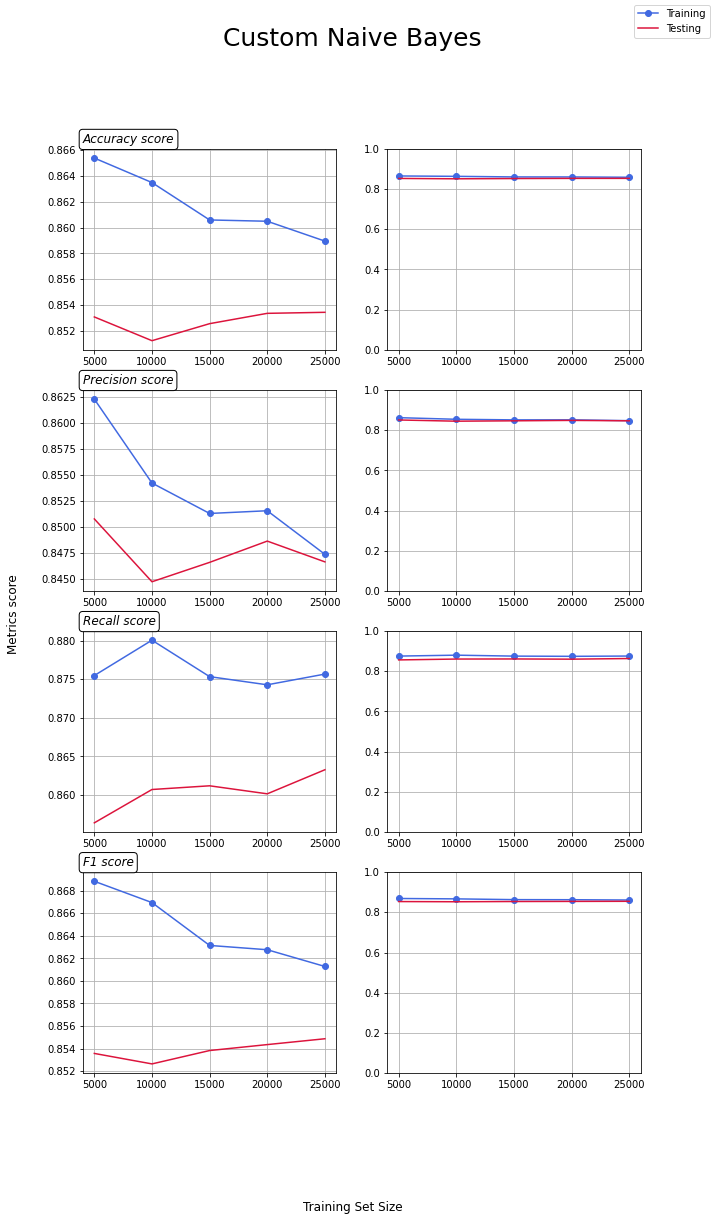

In [14]:
# Curves of Naive Bayes Classifier
nb = NaiveBayesClassifier()
report_NaiveBaseClassifier = learning_curve(predictor=nb, x_train=x_train_imdb_binary, y_train=y_train_imdb, x_test=x_test_imdb_binary, y_test=y_test_imdb, n_splits=5)

#### Scikit-Learn Naive Bayes

In [15]:
# Training Naive Bayes Classifier
nb_scikit = BernoulliNB()
nb_scikit.fit(x_train_imdb_binary, y_train_imdb)

# Using Naive Bayes Classifier
y_scikit = nb_scikit.predict(x_test_imdb_binary)
print(classification_report(y_test_imdb, y_scikit))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.85      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.865,0.853,0.862,0.851,0.875,0.856,0.869,0.854
40.0,0.864,0.851,0.854,0.845,0.880,0.861,0.867,0.853
60.0,0.861,0.853,0.851,0.847,0.875,0.861,0.863,0.854
80.0,0.861,0.853,0.852,0.849,0.874,0.860,0.863,0.854
100.0,0.859,0.853,0.847,0.847,0.876,0.863,0.861,0.855


C:\Users\chris\AppData\Local\Temp/ipykernel_17840/1022091208.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")


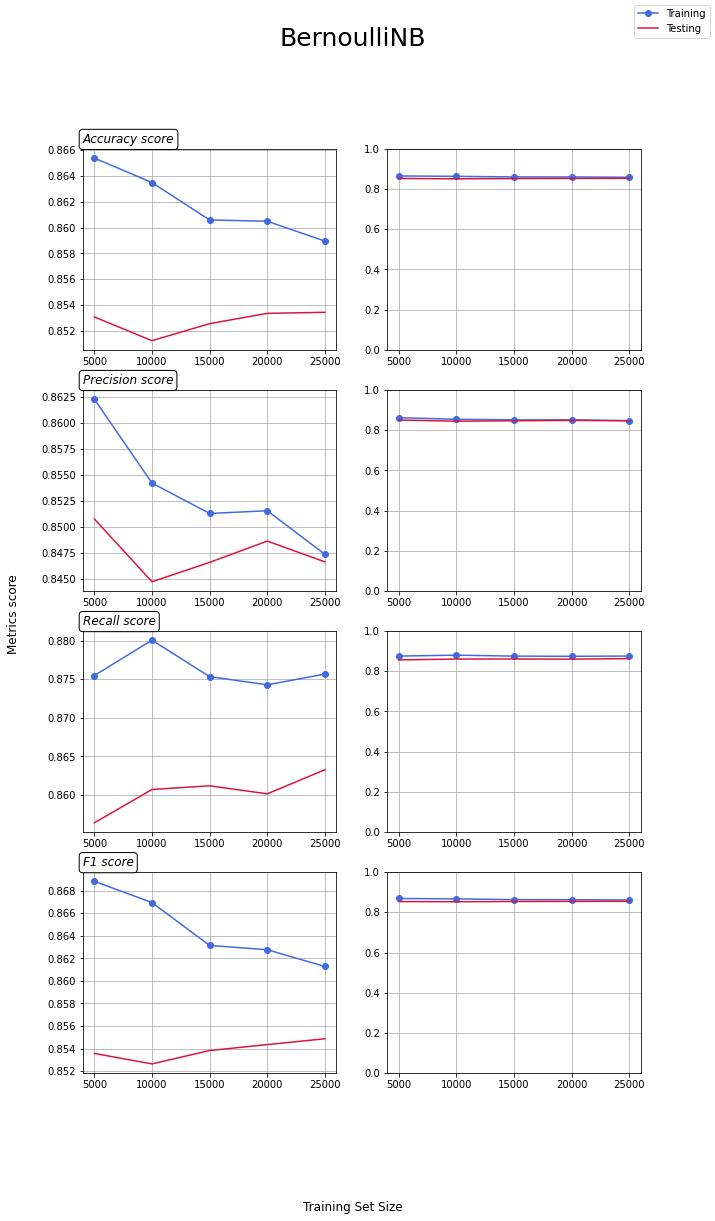

In [16]:
# Curves of Naive Bayes Classifier
nb_scikit = BernoulliNB()
report_BernoulliNB = learning_curve(predictor=nb_scikit, x_train=x_train_imdb_binary, y_train=y_train_imdb, x_test=x_test_imdb_binary, y_test=y_test_imdb, n_splits=5)

#### Comparisons

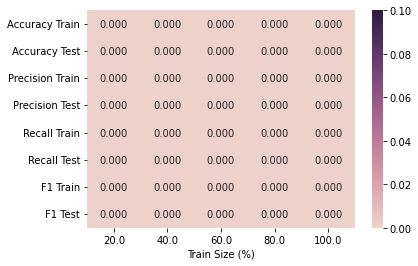

In [17]:
make_comparisons(df_predictor1=report_NaiveBaseClassifier, df_predictor2=report_BernoulliNB)

### Training, Using and Curves of Logistic Regression Classifier

#### Custom Logistic Regression

In [18]:
x_train_part, x_val_part, y_train_part, y_val_part = train_test_split(x_train_imdb_binary, y_train_imdb, test_size=0.1)

# Find best Logistic Regression Classifier (best λ factor of regularization)
best_classifier, best_regularizator, best_acc = find_best_regularizator(x_train_part=x_train_part, x_val_part=x_val_part, y_train_part=y_train_part, y_val_part=y_val_part)
print('Best validation data accuracy:', best_acc)
print('Best regularizator factor:', best_regularizator)

lr = best_classifier

# Using Logistic Regression Classifier
y = lr.predict(x_test_binary=x_test_imdb_binary)
print(classification_report(y_test_imdb, y))

Best epoch: 21
	Regularizator:  1e-15 Accuracy on dev:  0.8828
Best epoch: 12
	Regularizator:  0.010000000000001 Accuracy on dev:  0.86
Best epoch: 21
	Regularizator:  0.020000000000001 Accuracy on dev:  0.85
Best epoch: 8
	Regularizator:  0.030000000000000998 Accuracy on dev:  0.8444
Best epoch: 6
	Regularizator:  0.040000000000001 Accuracy on dev:  0.8384
Best epoch: 8
	Regularizator:  0.050000000000001 Accuracy on dev:  0.8404
Best validation data accuracy: 0.8828
Best regularizator factor: 1e-15
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



Best epoch: 27
	Regularizator:  1e-15 Accuracy on dev:  0.8732
Best epoch: 20
	Regularizator:  0.010000000000001 Accuracy on dev:  0.8504
Best epoch: 27
	Regularizator:  0.020000000000001 Accuracy on dev:  0.844
Best epoch: 23
	Regularizator:  0.030000000000000998 Accuracy on dev:  0.8324
Best epoch: 3
	Regularizator:  0.040000000000001 Accuracy on dev:  0.8344
Best epoch: 22
	Regularizator:  0.050000000000001 Accuracy on dev:  0.8348
Best validation data accuracy: 0.8732
Best regularizator factor: 1e-15
Best epoch: 45


  0%|          | 0/4 [00:00<?, ?it/s]

Best epoch: 33


 25%|██▌       | 1/4 [00:06<00:20,  6.80s/it]

Best epoch: 36


 50%|█████     | 2/4 [00:17<00:17,  8.89s/it]

Best epoch: 36


 75%|███████▌  | 3/4 [00:30<00:11, 11.14s/it]

Best epoch: 39


100%|██████████| 4/4 [00:49<00:00, 12.31s/it]


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
16.0,0.908,0.852,0.910,0.846,0.903,0.861,0.907,0.853
32.0,0.891,0.863,0.892,0.864,0.890,0.862,0.891,0.863
48.0,0.895,0.869,0.879,0.855,0.915,0.889,0.896,0.871
64.0,0.895,0.870,0.882,0.856,0.911,0.891,0.896,0.873
80.0,0.895,0.872,0.889,0.865,0.905,0.881,0.897,0.873


C:\Users\chris\AppData\Local\Temp/ipykernel_17840/1022091208.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")


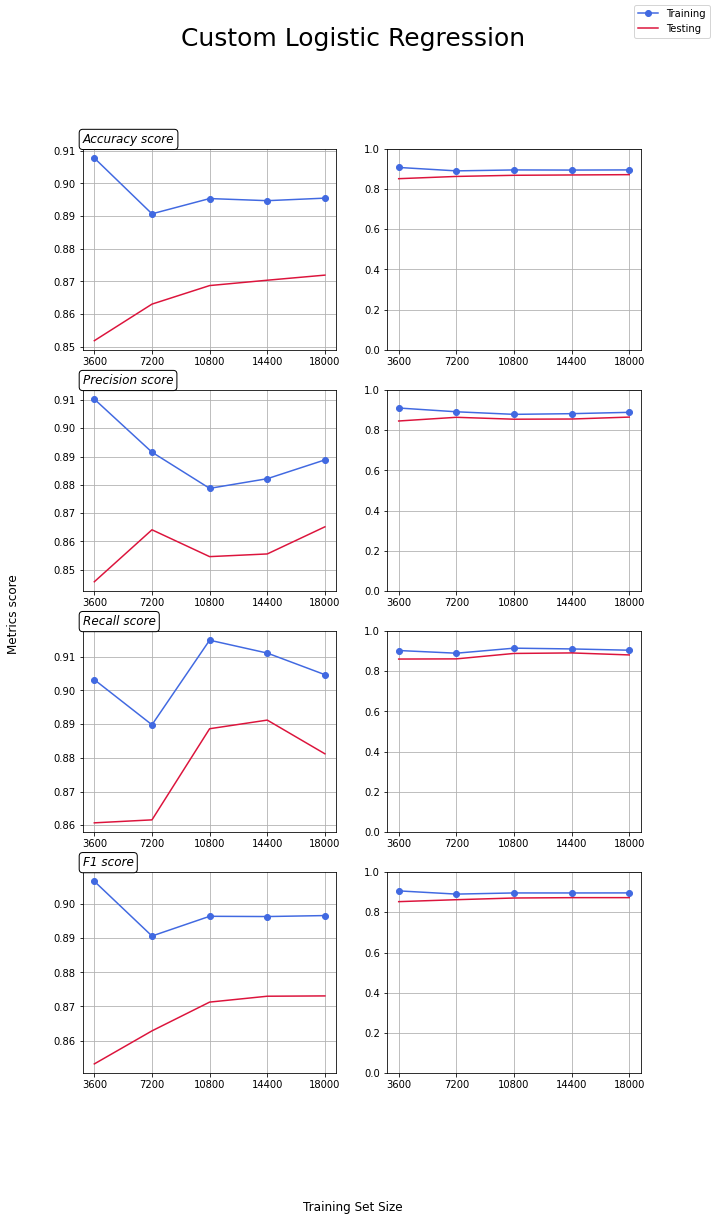

In [19]:
x_train_part, x_val_part, y_train_part, y_val_part = train_test_split(x_train_imdb_binary, y_train_imdb, test_size=0.1)

# Find best Logistic Regression Classifier (best λ factor of regularization)
best_classifier, best_regularizator, best_acc = find_best_regularizator(x_train_part=x_train_part, x_val_part=x_val_part, y_train_part=y_train_part, y_val_part=y_val_part)
print('Best validation data accuracy:', best_acc)
print('Best regularizator factor:', best_regularizator)

lr = best_classifier

# Curves of Logistic Regression Classifier
report_customLogisticRegression = learning_curve(predictor=lr, x_train=x_train_part, y_train=y_train_part, x_test=x_test_imdb_binary, y_test=y_test_imdb, n_splits=5)

#### Scikit-Learn Logistic Regression

In [20]:
# Training Logistic Regression Classifier
log = LogisticRegression(max_iter=100, C=1e15, solver='saga')
log.fit(x_train_imdb_binary, y_train_imdb)

# Using Logistic Regression Classifier
y_log_scikit = log.predict(x_test_imdb_binary)
print(classification_report(y_test_imdb, y_log_scikit))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 1/4 [00:08<00:26,  8.77s/it]c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 50%|█████     | 2/4 [00:21<00:22, 11.14s/it]c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 75%|███████▌  | 3/4 [00:38<00:13, 13.83s/it]

,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.939,0.840,0.938,0.840,0.943,0.840,0.940,0.840
40.0,0.908,0.856,0.905,0.854,0.914,0.858,0.909,0.856
60.0,0.898,0.861,0.893,0.859,0.905,0.864,0.899,0.862
80.0,0.898,0.869,0.893,0.864,0.906,0.875,0.899,0.869
100.0,0.893,0.871,0.888,0.865,0.899,0.879,0.894,0.872


C:\Users\chris\AppData\Local\Temp/ipykernel_17840/1022091208.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")


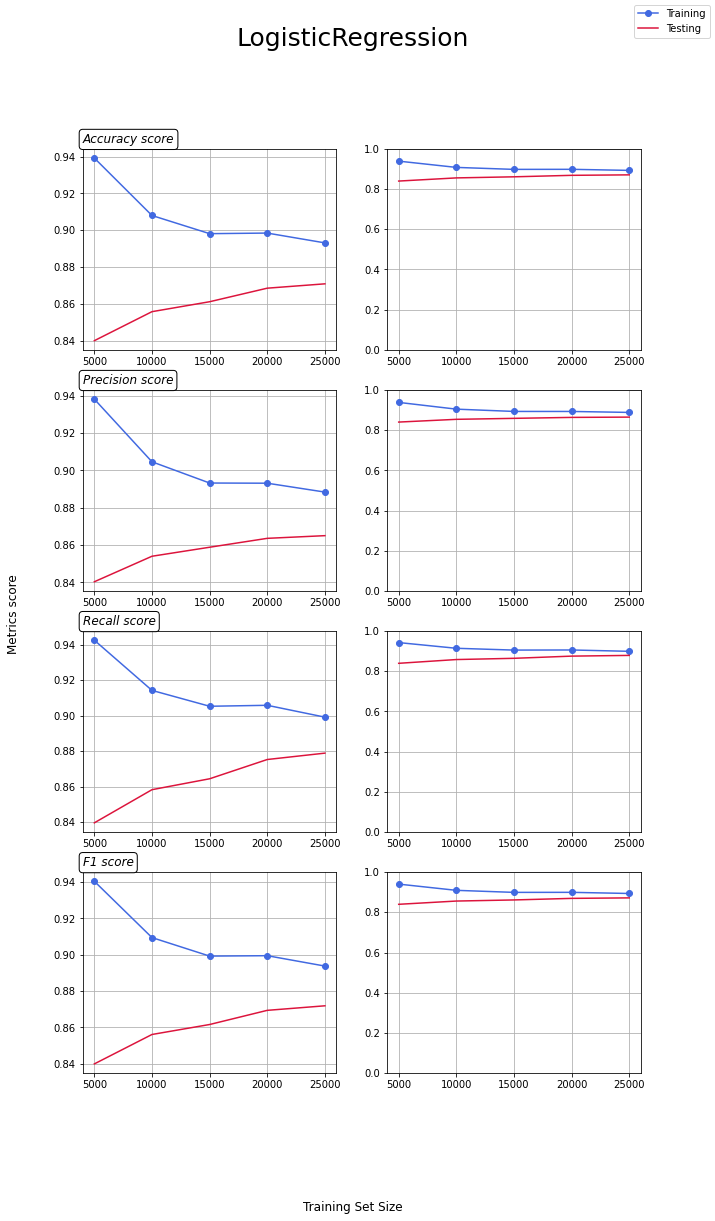

In [21]:
# Curves of Logistic Regression Classifier
log = LogisticRegression(max_iter=100, C=1e15, solver='saga')
report_LogisticRegression = learning_curve(predictor=log, x_train=x_train_imdb_binary, y_train=y_train_imdb, x_test=x_test_imdb_binary, y_test=y_test_imdb, n_splits=5)

#### Scikit-Learn SGDClassifier

In [22]:
# Training Logistic Regression Classifier
log_sgd = SGDClassifier(loss='log', max_iter=100, early_stopping=True)
log_sgd.fit(x_train_imdb_binary, y_train_imdb)

# Using Logistic Regression Classifier
y_log_sgd_scikit = log_sgd.predict(x_test_imdb_binary)
print(classification_report(y_test_imdb, y_log_sgd_scikit))

c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.91      0.86     12500
           1       0.90      0.81      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
 25%|██▌       | 1/4 [00:00<00:01,  2.46it/s]c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
 50%|█████     | 2/4 [00:00<00:00,  2.01it/s]c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\si

,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.908,0.819,0.921,0.832,0.896,0.798,0.908,0.815
40.0,0.888,0.842,0.865,0.820,0.923,0.878,0.893,0.848
60.0,0.875,0.844,0.847,0.817,0.917,0.886,0.880,0.850
80.0,0.888,0.862,0.914,0.888,0.857,0.829,0.885,0.858
100.0,0.865,0.847,0.812,0.795,0.949,0.934,0.875,0.859


C:\Users\chris\AppData\Local\Temp/ipykernel_17840/1022091208.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")


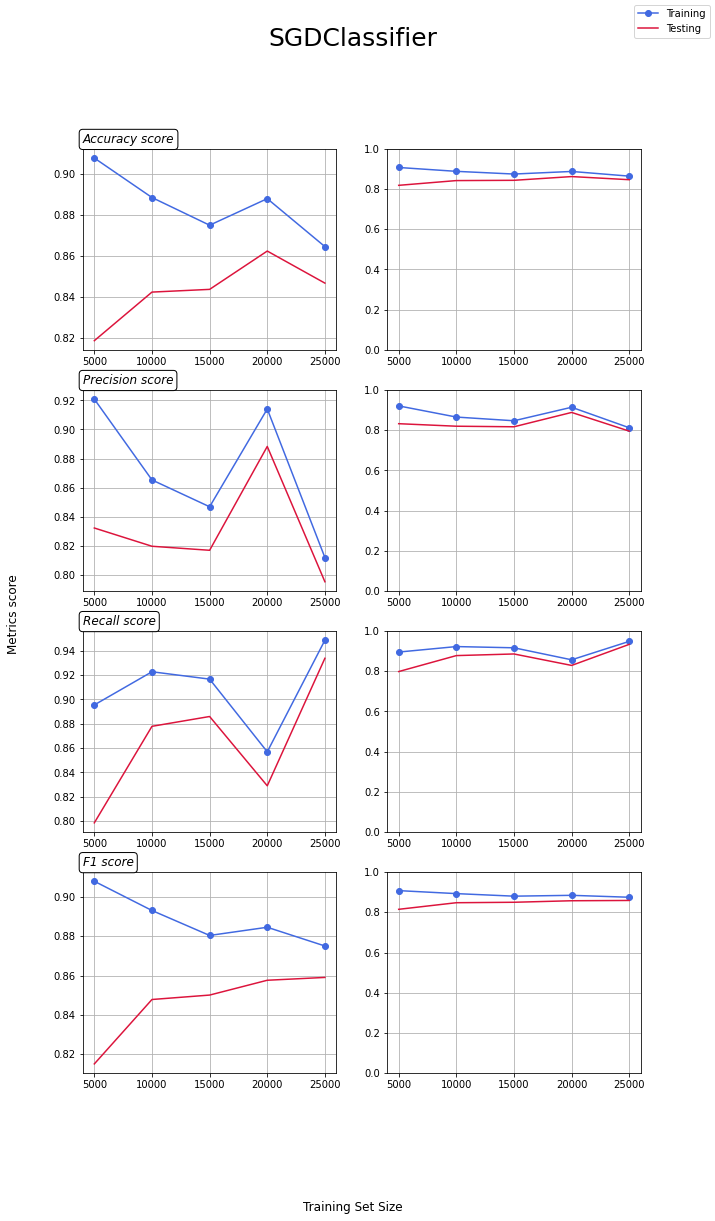

In [23]:
# Curves of Logistic Regression Classifier
log_sgd = SGDClassifier(loss='log', max_iter=100, early_stopping=True)
report_SGDClassifier = learning_curve(predictor=log_sgd, x_train=x_train_imdb_binary, y_train=y_train_imdb, x_test=x_test_imdb_binary, y_test=y_test_imdb, n_splits=5)

#### Comparisons

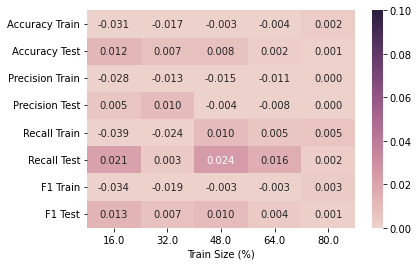

In [24]:
make_comparisons(df_predictor1=report_customLogisticRegression, df_predictor2=report_LogisticRegression)


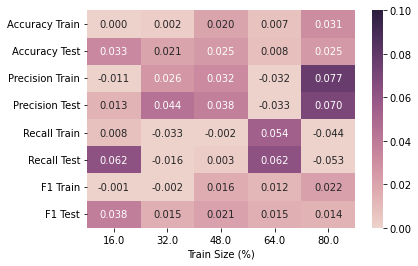

In [25]:
make_comparisons(df_predictor1=report_customLogisticRegression, df_predictor2=report_SGDClassifier)

### Bidirectional RNN with GRU cells

In [26]:
# Estimating the sequence (example review) length (average length of all reviews in training data)
import statistics
sample = []
for example in tqdm(x_train_imdb):
  tokens = str(example).split()
  sample.append(len(tokens))

print(math.ceil(statistics.mean(sample) + 2.581 * statistics.stdev(sample)/math.sqrt(len(sample))))    # 99% confidence interval

100%|██████████| 25000/25000 [00:00<00:00, 26221.77it/s]


242


In [27]:
# Embedding layer creates word embeddings by mapping integer encoded sequences to dense vectors, 
# so we first convert the examples (sequences) to integer vectors

SEQ_MAX_LENGTH = 245
vectorizer = tf.keras.layers.TextVectorization(output_mode='int', 
                                               ngrams=1, name='vector_text',
                                               output_sequence_length=SEQ_MAX_LENGTH,
                                               vocabulary=list(vocabulary.keys()))

In [28]:
# Training RNN
rnn = BiGRU_RNN(vectorizer=vectorizer, num_layers=1, emb_size=64, h_size=64)
rnn.fit(x_train=x_train_imdb, y_train=y_train_imdb, epochs=1, verbose=1, batch_size=64)

plot_model(rnn.model, to_file='model.png', show_shapes=True)
Image('model.png')

# Using RNN
y_pred = rnn.predict(x_test = x_test_imdb)
print(classification_report(y_test_imdb, y_pred))

782/782 [==============================] - 23s 26ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     12500
           1       0.84      0.80      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



782/782 [==============================] - 21s 27ms/step


  0%|          | 0/4 [00:00<?, ?it/s]

782/782 [==============================] - 22s 28ms/step


 25%|██▌       | 1/4 [01:34<04:42, 94.27s/it]

782/782 [==============================] - 31s 40ms/step


 50%|█████     | 2/4 [03:55<04:04, 122.08s/it]

782/782 [==============================] - 25s 29ms/step


 75%|███████▌  | 3/4 [06:05<02:05, 125.41s/it]

782/782 [==============================] - 58s 74ms/step


100%|██████████| 4/4 [11:46<00:00, 176.70s/it]


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.530,0.520,0.520,0.510,0.996,0.995,0.683,0.674
40.0,0.589,0.582,0.552,0.546,0.987,0.983,0.708,0.702
60.0,0.854,0.840,0.861,0.852,0.846,0.823,0.854,0.838
80.0,0.843,0.832,0.877,0.869,0.798,0.782,0.836,0.823
100.0,0.861,0.850,0.866,0.858,0.855,0.838,0.860,0.848


C:\Users\chris\AppData\Local\Temp/ipykernel_17840/1022091208.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")


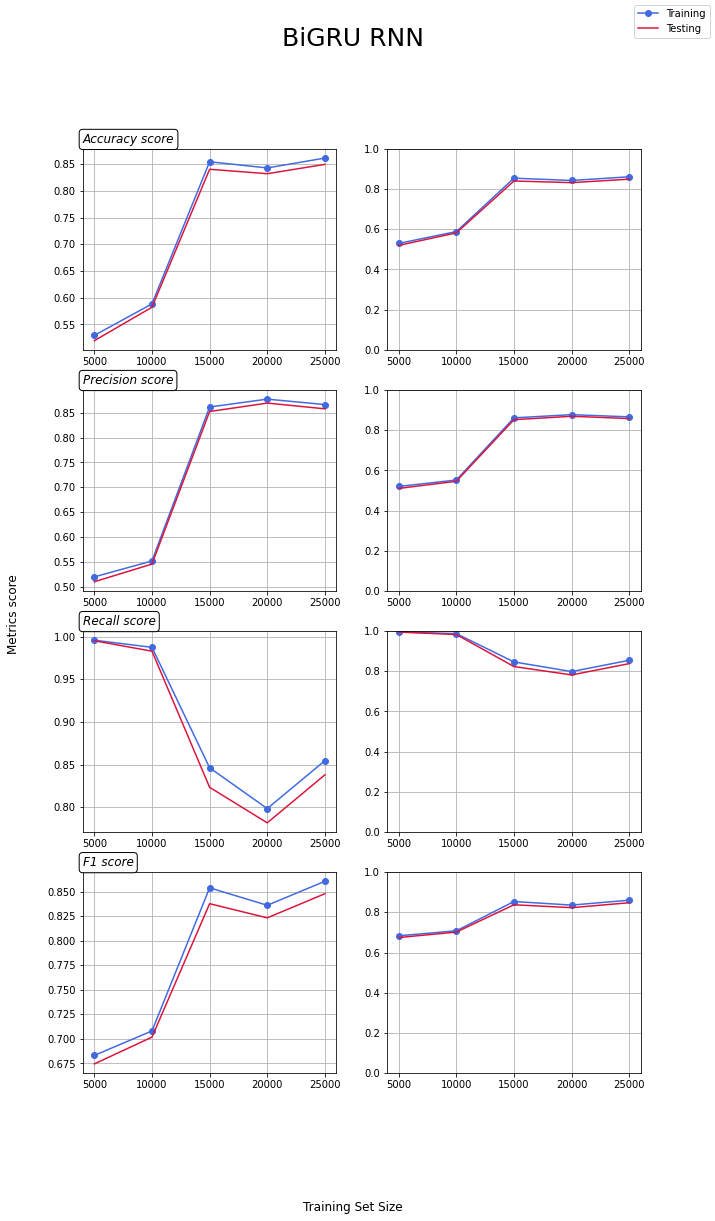

In [29]:
# Curves of RNN 
rnn = BiGRU_RNN(vectorizer=vectorizer, num_layers=1, emb_size=64, h_size=64)
report_BiGRU_RNN = learning_curve(rnn, x_train=x_train_imdb, y_train=y_train_imdb, x_test=x_test_imdb, y_test=y_test_imdb, n_splits=5)

Epoch 1/5
625/625 [==============================] - 174s 267ms/step - loss: 0.5914 - binary_accuracy: 0.6519 - precision_6: 0.6312 - recall_6: 0.7358 - val_loss: 0.3967 - val_binary_accuracy: 0.8240 - val_precision_6: 0.7724 - val_recall_6: 0.9125
Epoch 2/5
625/625 [==============================] - 157s 251ms/step - loss: 0.3576 - binary_accuracy: 0.8443 - precision_6: 0.8386 - recall_6: 0.8541 - val_loss: 0.3789 - val_binary_accuracy: 0.8430 - val_precision_6: 0.8983 - val_recall_6: 0.7691
Epoch 3/5
625/625 [==============================] - 171s 274ms/step - loss: 0.3184 - binary_accuracy: 0.8648 - precision_6: 0.8604 - recall_6: 0.8720 - val_loss: 0.3324 - val_binary_accuracy: 0.8598 - val_precision_6: 0.8771 - val_recall_6: 0.8327
Epoch 4/5
625/625 [==============================] - 172s 274ms/step - loss: 0.3048 - binary_accuracy: 0.8723 - precision_6: 0.8690 - recall_6: 0.8779 - val_loss: 0.3416 - val_binary_accuracy: 0.8522 - val_precision_6: 0.8199 - val_recall_6: 0.8979
Epoc

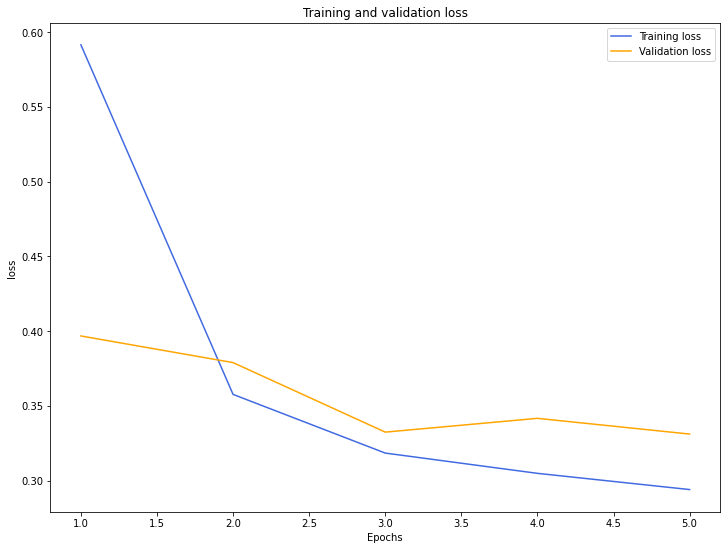

In [30]:
# Loss curves of RNN
rnn = BiGRU_RNN(vectorizer=vectorizer, num_layers=1, emb_size=64, h_size=64)
his = rnn.fit(x_train=x_train_imdb, y_train=y_train_imdb, epochs=5, verbose=1, batch_size=32, validation_split=0.2)

loss_plot(his)

#### Comparisons

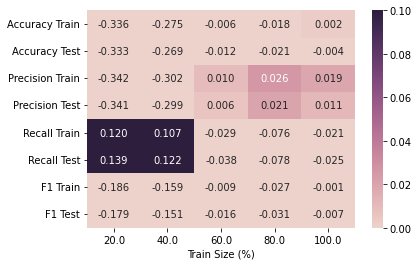

In [31]:
make_comparisons(df_predictor1=report_BiGRU_RNN, df_predictor2=report_NaiveBaseClassifier)

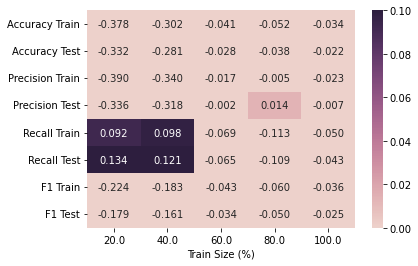

In [32]:
make_comparisons(df_predictor1=report_BiGRU_RNN, df_predictor2=report_customLogisticRegression)